In [1]:
import numpy as np
import scipy.optimize as opt

In [2]:
opt.minimize(lambda x:x[0]**2+2*x[1],[3,2],bounds=((None,None),(-2,5)))

      fun: -4.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  1.99999999])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([ -2.13263771e-09,  -2.00000000e+00])

In [3]:
def f(xy):
    x, y, = xy
    return x**2+2*y

In [4]:
opt.minimize(f, [3,2], bounds=((None,None),(-2,5)))

      fun: -4.0
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  1.99999999])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 21
      nit: 6
   status: 0
  success: True
        x: array([ -2.13263771e-09,  -2.00000000e+00])

# My problem

In [5]:
import numpy as np
import scipy.optimize as opt
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [80]:
T = 40

# Income at time t, should be i(t)
def y(t):
    return 50000*np.exp(.03*t)

# Non-risky Investment rate
r = .04

# Continuous process (think average return rate of risky investment)
mu = .09

# Standard deviation of risky investment
sigma = .18

# Utility discount rate
rho = .03

# Hazard Function (probability of death at this moment in time)
def lamb(t):
    return 1/200 + 9/8000*t

# Insurance premium-payout ratio
def eta(t):
    return 1/200 + 9/8000*t

# Relative risk aversion
gamma = -3

def integral(f, t0, tf):
    # f is a function
    return quad(f, t0, tf)[0]

# Integral function doesn't play nice with sums of constants and functions
def sum_r(t):
    return r+eta(t)
def sum_rho(t):
    return lamb(t)+rho

def H(v):
    return sum_rho(v)/(1-gamma) - .5*gamma*((mu-r)/((1-gamma)*sigma))**2 - \
                                gamma/(1-gamma)*sum_r(v)

def K(s):
    return (lamb(s)**(1/(1-gamma)))/eta(s)**(gamma/(1-gamma)) + 1

def e(t):
    return np.exp(-integral(H,t,T)) + integral(lambda s: np.exp(-integral(H,t,s))*K(s),t,T)
    
def a(t):
    return np.exp(-rho*t)*e(t)**(1-gamma)

def b(t):
    return integral(lambda s: y(s)*np.exp(-integral(sum_r,t,s)),t,T)

def c(t):
    return (1/e(t))*(x+b(t))

def D(t):
    return (lamb(t)/eta(t))**(1/(1-gamma))*1/e(t)

def Z(t):
    return D(t)*(x+b(t))

def theta(t):
    return ((mu-r)/((1-gamma)*sigma**2))*(x+b(t))

def p(t):
    return eta(t)*((D(t)-1)*x+D(t)*b(t))

def V(t,x):
    return a(t)/gamma*(x+b(t))**gamma

# These utility definitions come in 4.3, pg 69
# Utility of consumption c 
def U(c,t):
    return np.exp(-rho*t)/gamma * c**gamma

# Utility of bequeathance Z, if dead early
def B(Z,t):
    return np.exp(-rho*t)/gamma * Z**gamma

# Utility of wealth remaining after T
def L(x,T):
    return np.exp(-rho*T)/gamma * x**gamma

# These are the 'Transition Probabilities' on pg 68.
# 3 fumctions are created for ease of substitution
# Because there is no dependence on u, I will just make them functions of t, theta_hat, c_hat, Z_hat for optimization

def Pplus(theta_hat,t):
    return delta/h*(r+eta(t)+theta_hat*(mu-r)) + (delta/(2*h**2))*(sigma**2)*(theta_hat**2)

def Pminus(theta_hat, c_hat, Z_hat, t):
    return (delta/(2*h**2))*(sigma**2)*(theta_hat**2) + (delta/(2*h))*(sigma**2)*(theta_hat**2) + (delta/h)*(c_hat+eta(t)*Z_hat)

def P(theta_hat, c_hat, Z_hat, t):
    return 1-Pplus(theta_hat,t)-Pminus(theta_hat, c_hat, Z_hat, t)

# Think of a means to save V_hat values to avoid repetition, significantly reduce the # of computations
def V_hat(t, u, T):
    # This will be a recursive function. It should terminate at t=T
#     if t==T:
    return L(np.exp(u),T)

# Define the function to minimize with parameters strictly in theta_hat, c_hat, Z_hat
def f(params, u, t, T, sign=1.0):
    theta_hat, c_hat, Z_hat = params
    return 1e20*-1*1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

def g(params, u, t, T):
    theta_hat, c_hat, Z_hat = params
    return -1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

In [81]:
u = 14
delta = .001
h = .02
t = T - delta

z = 1-np.exp(-u)*b(t)
print(z)

sol = opt.minimize(f, [.6, .7, 1-np.exp(-u)*b(t)], args=(u,t,T), bounds=((0,1),(0,1),(None,None)))
print(sol)

0.999861969653
      fun: 5.7952496021157165
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -8.8817841970e-08,   2.6645352591e-06,   3.9968028887e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 40
      nit: 9
   status: 0
  success: True
        x: array([ 0.3714595733,  0.9925338082,  0.9935948337])


# If $Z$ and $c$ are fixed, we easily see $\max\limits_\theta \{f\}$ occurs around $\theta=.371$, which is expected

0.999861969653 14 39.999 40


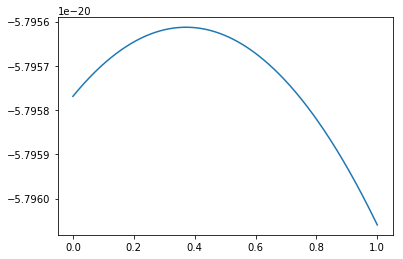

In [57]:
print(z, u, t, T)

THETA = np.linspace(0,1,10000)
plt.plot(THETA, -1e-20*f((THETA, .9, z), u, t, T))
plt.show()

In [58]:
def f_theta(theta_hat, c_hat, Z_hat, u, t, T):
    return 1e20*-1*1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

opt.minimize(f_theta, .8, args=(.9, z, u, t, T))

      fun: 5.795612859501656
 hess_inv: array([[ 442.1726703984]])
      jac: array([ -1.7881393433e-07])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 3
     njev: 7
   status: 0
  success: True
        x: array([ 0.3714879823])

In [60]:
np.set_printoptions(precision=10)
print(-1e-20*f((THETA, .9, z), u, t, T))

[ -5.7957689680e-20  -5.7957688840e-20  -5.7957688000e-20 ...,
  -5.7960592678e-20  -5.7960594099e-20  -5.7960595521e-20]


In [61]:
np.argsort(-f((THETA, .9, z), u, t, T))

array([9999, 9998, 9997, ..., 3716, 3714, 3715], dtype=int64)

# Now we fix $\theta$ and $Z$, and see that $\max\limits_c\{f\}$ occurs at $c=.992$, which is about what is expected

In [62]:
def f_c(c_hat, theta_hat, Z_hat, u, t, T):
    return 1e20*-1*1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

opt.minimize(f_c, .9, args=(.371, z, u, t, T))

      fun: 5.795249696531143
 hess_inv: array([[ 13.776211765]])
      jac: array([ -5.9604644775e-08])
  message: 'Optimization terminated successfully.'
     nfev: 21
      nit: 6
     njev: 7
   status: 0
  success: True
        x: array([ 0.9924980085])

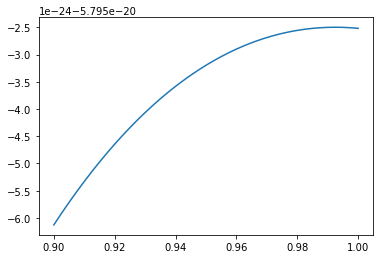

In [63]:
C = np.linspace(.9,1,1000)

plt.plot(C, -1e-20*f_c(C, .371, z, u, t, T))
plt.show()

# Now fix just $Z$, we get $\max\limits_{c,\theta}\{f\}$ occurs at $c=.9925$, $\theta=.3715$ which is about what's expected

In [64]:
def f_c_theta(ct, Z_hat, u, t, T):
    c_hat, theta_hat = ct
    return 1e20*-1*1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

opt.minimize(f_c_theta, (.9,.3), args=(z, u, t, T))

      fun: 5.795249696663299
 hess_inv: array([[  13.9832427501,    0.7975237531],
       [   0.7975237531,  354.4950398951]])
      jac: array([ -4.7683715820e-07,   1.4305114746e-06])
  message: 'Optimization terminated successfully.'
     nfev: 72
      nit: 17
     njev: 18
   status: 0
  success: True
        x: array([ 0.9924908043,  0.3721588875])

# Fix $c$ and $theta$. Notice $f$ is linear in $Z$, so we must add in the fact that $P_{plus}$, $P_{minus}$, and $P$ are all positive (they are technically transition probabilities, and forcing them all positive forces them between $0$ and $1$ since $P=1-P_{plus}-P_{minus}$).

In [65]:
def f_z(Z_hat, theta_hat, c_hat, u, t, T):
    return 1e20*-1*1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

theta_hat = .371
c_hat = .992
# Z is free

cons = ({'type': 'ineq', 'fun': lambda x: Pplus(theta_hat, t)},
        {'type': 'ineq', 'fun': lambda x: Pminus(theta_hat, c_hat, x, t)},
        {'type': 'ineq', 'fun': lambda x: P(theta_hat, c_hat, x, t)})

sol = opt.minimize(f_z, 1-np.exp(-u)*b(t), args=(theta_hat, c_hat, u, t, T), constraints=cons)
print(sol)

     fun: 5.7952497054675325
     jac: array([  2.5987625122e-05])
 message: 'Optimization terminated successfully.'
    nfev: 3
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([ 0.9998619697])


0.999861969653


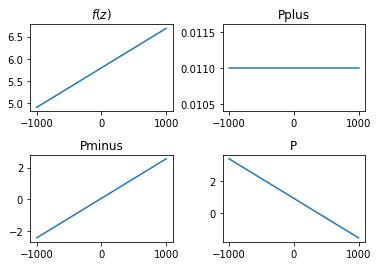

In [66]:
print(z)

Zs = np.linspace(-1000,1000,1000)

plt.subplot(221)
plt.plot(Zs, f_z(Zs, .371, .992, u, t, T))
plt.title('$f(z)$')

plt.subplot(222)
plt.plot(Zs, Pplus(.371, t)*np.ones(len(Zs)))
plt.title('Pplus')

plt.subplot(223)
plt.plot(Zs, Pminus(.371, .992, Zs, t))
plt.title('Pminus')

plt.subplot(224)
plt.plot(Zs, P(.371, .992, Zs, t))
plt.title('P')

plt.subplots_adjust(hspace=.5, wspace=.35)
plt.show()

# Now let everything be free.

In [82]:
def f_all(params, u, t, T, delta, h):
    theta_hat, c_hat, Z_hat = params
    return 1e21*-1/(1+delta*lamb(t))* \
        (Pplus(theta_hat,t)*V_hat(t+delta,u+h,T) +\
        P(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u,T) +\
        Pminus(theta_hat,c_hat,Z_hat,t)*V_hat(t+delta,u-h,T) +\
        delta*lamb(t)*B(np.exp(u)*Z_hat,t) +\
        delta*U(np.exp(u)*c_hat,t))

# cons = ({'type': 'ineq', 'fun': lambda x: Pplus(theta_hat, t)},
#         {'type': 'ineq', 'fun': lambda x: Pminus(theta_hat, c_hat, x, t)},
#         {'type': 'ineq', 'fun': lambda x: P(theta_hat, c_hat, x, t)})

cons = ({'type': 'ineq', 'fun': lambda x: Pplus(x[0], t)},
        {'type': 'ineq', 'fun': lambda x: Pminus(x[0], x[1], x[2], t)},
        {'type': 'ineq', 'fun': lambda x: P(x[0], x[1], x[2], t)})

# cons=None

z = 1-np.exp(-u)*b(t)
print(z)

sol = opt.minimize(f_all, [.1, .2, 1-np.exp(-u)*b(t)], args=(u,t,T,delta,h), bounds=((0,1),(0,1),(None,None)), constraints=cons)
print(sol)

0.999861969653
     fun: 57.95249741424585
     jac: array([  2.8610229492e-06,   4.6205520630e-04,   2.9802322388e-04])
 message: 'Optimization terminated successfully.'
    nfev: 76
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([ 0.3716790634,  0.9931405999,  1.0009510452])


In [77]:
print(Pplus(sol.x[0],t), Pminus(sol.x[0], sol.x[1], sol.x[2], t), P(sol.x[0], sol.x[1], sol.x[2], t))

0.0110717480611 0.0578876533733 0.931040598566
